In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Scripts debugging

In [0]:
# Importing necessary libs
import tensorflow as tf

import os
os.chdir("/content/drive/My Drive/IDL-Ex-Colab/resources")
from datasets import MNISTDataset
from time import time

In [0]:
os.chdir("/content/drive/My Drive/IDL-Ex-Colab/resources")
# get the data
(train_imgs, train_lbls), (test_imgs, test_lbls) = tf.keras.datasets.mnist.load_data()
mnist = MNISTDataset(train_imgs.reshape((-1, 784)), train_lbls,
                     test_imgs.reshape((-1, 784)), test_lbls,
                     batch_size=256, seed=int(time()))

11493376/11490434 [==============================] - 0s 0us/step


## Script 1

In [0]:
os.chdir("/content/drive/My Drive/IDL-Ex-Colab")
logdir = os.path.join("logs", "FAIL/1", str(time()))
train_writer = tf.summary.create_file_writer(os.path.join(logdir, "train"))

# define the model first, from input to output

# this is a super deep model, cool!
n_units = 100
n_layers = 8
w_range = 0.4

# just set up a "chain" of hidden layers
layers = []
for layer in range(n_layers):
    layers.append(tf.keras.layers.Dense(
        n_units, activation=tf.nn.relu,
        kernel_initializer=tf.initializers.RandomUniform(minval=-w_range,
                                                         maxval=w_range),
        bias_initializer=tf.initializers.constant(0.001))
    )

# finally add the output layer
layers.append(tf.keras.layers.Dense(
    10, kernel_initializer=tf.initializers.RandomUniform(minval=-w_range,
                                                         maxval=w_range)))

lr = 0.1
for step in range(2000):
    img_batch, lbl_batch = mnist.next_batch()
    with tf.GradientTape() as tape:
        # here we just run all the layers in sequence via a for-loop
        out = img_batch
        for layer in layers:
            out = layer(out)
        xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=out, labels=lbl_batch))

    weights = [var for l in layers for var in l.trainable_variables]
    grads = tape.gradient(xent, weights)
    for grad, var in zip(grads, weights):
      var.assign_sub(lr*grad)

    # Logging loss
    with train_writer.as_default():
        tf.summary.scalar("loss_1", xent, step=step)
        tf.summary.histogram("logits_1", out, step=step)
        grad_index = 0
        for layer in layers:
          with tf.name_scope(layer.name):
            tf.summary.histogram("weight_1", layer.weights[0], step=step)
            tf.summary.histogram("gradient_1", grads[grad_index], step=step)
            grad_index += 2

    if not step % 100:
        preds = tf.argmax(out, axis=1, output_type=tf.int32)
        acc = tf.reduce_mean(tf.cast(tf.equal(preds, lbl_batch), tf.float32))
        with train_writer.as_default():
            tf.summary.scalar("accuracy_1", acc, step=step)
            tf.summary.image("input_1", tf.reshape(img_batch, [-1, 28, 28, 1]), step=step)
        print("Loss: {} Accuracy: {}".format(xent, acc))

out = mnist.test_data
for layer in layers:
    out = layer(out)
test_preds = tf.argmax(out, axis=1, output_type=tf.int32)
acc = tf.reduce_mean(tf.cast(tf.equal(test_preds, mnist.test_labels), tf.float32))
print("Final test accuracy: {}".format(acc))

Loss: 170.9481658935547 Accuracy: 0.18359375
Loss: nan Accuracy: 0.09765625
Starting new epoch...
Loss: nan Accuracy: 0.12109375
Loss: nan Accuracy: 0.125
Loss: nan Accuracy: 0.125
Starting new epoch...
Loss: nan Accuracy: 0.1015625
Loss: nan Accuracy: 0.07421875
Starting new epoch...
Loss: nan Accuracy: 0.0859375
Loss: nan Accuracy: 0.08984375
Starting new epoch...
Loss: nan Accuracy: 0.09375
Loss: nan Accuracy: 0.09765625
Loss: nan Accuracy: 0.08984375
Starting new epoch...
Loss: nan Accuracy: 0.08203125
Loss: nan Accuracy: 0.12109375
Starting new epoch...
Loss: nan Accuracy: 0.08203125
Loss: nan Accuracy: 0.10546875
Starting new epoch...
Loss: nan Accuracy: 0.09375
Loss: nan Accuracy: 0.1171875
Loss: nan Accuracy: 0.10546875
Starting new epoch...
Loss: nan Accuracy: 0.125
Final test accuracy: 0.09799999743700027


In [0]:
%load_ext tensorboard

In [0]:
%tensorboard --logdir logs

### Problem with Script 1
For the first time Loss is nearly 130 due to high weight initialization. Inputs will affect output either small or large. This affected cost to go negative after few epochs. 
Gradients are saturated at 0 due to high number of layers and model didn't learnt anything and accuarcy is very less. (Problem of Vanishing Gradients)

### Solution
Keeping number of layers low ex 2, giving good accuracy 

## Script 2

In [0]:
# get the data
(train_imgs, train_lbls), (test_imgs, test_lbls) = tf.keras.datasets.mnist.load_data()
mnist = MNISTDataset(train_imgs.reshape((-1, 784)), train_lbls,
                     test_imgs.reshape((-1, 784)), test_lbls,
                     batch_size=256, seed=int(time()))

os.chdir("/content/drive/My Drive/IDL-Ex-Colab")
logdir = os.path.join("logs", "FAIL/2", str(time()))
train_writer = tf.summary.create_file_writer(os.path.join(logdir, "train"))
# define the model first, from input to output

# this is a super deep model, cool!
n_units = 100
n_layers = 2 # Changed from 8 to 2
w_range = 0.1

# just set up a "chain" of hidden layers
layers = []
for layer in range(n_layers):
    layers.append(tf.keras.layers.Dense(
        n_units, activation=tf.nn.sigmoid,
        kernel_initializer=tf.initializers.RandomUniform(minval=-w_range,
                                                         maxval=w_range),
        bias_initializer=tf.initializers.constant(0.001)))

# finally add the output layer
layers.append(tf.keras.layers.Dense(
    10, kernel_initializer=tf.initializers.RandomUniform(minval=-w_range,
                                                         maxval=w_range)))

lr = 0.1
for step in range(2000):
    img_batch, lbl_batch = mnist.next_batch()
    with tf.GradientTape() as tape:
        # here we just run all the layers in sequence via a for-loop
        out = img_batch
        for layer in layers:
            out = layer(out)
        xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=out, labels=lbl_batch))

    weights = [var for l in layers for var in l.trainable_variables]
    grads = tape.gradient(xent, weights)
    for grad, var in zip(grads, weights):
        var.assign_sub(lr*grad)

    # Logging loss
    grad_index = 0
    with train_writer.as_default():
        tf.summary.scalar("loss_2", xent, step=step)
        tf.summary.histogram("logits_2", out, step=step)
        for layer in layers:
          with tf.name_scope(layer.name):
            tf.summary.histogram("weight_2", layer.weights[0], step=step)
            tf.summary.histogram("gradient_2", grads[grad_index], step=step)
            grad_index += 2 # Skipping gradient of bias

    if not step % 100:
        preds = tf.argmax(out, axis=1, output_type=tf.int32)
        acc = tf.reduce_mean(tf.cast(tf.equal(preds, lbl_batch), tf.float32))
        with train_writer.as_default():
            tf.summary.scalar("accuracy_2", acc, step=step)
            tf.summary.image("input_2", tf.reshape(img_batch, [-1, 28, 28, 1]), step=step)
        print("Loss: {} Accuracy: {}".format(xent, acc))


out = mnist.test_data
for layer in layers:
    out = layer(out)
test_preds = tf.argmax(out, axis=1, output_type=tf.int32)
acc = tf.reduce_mean(tf.cast(tf.equal(test_preds, mnist.test_labels), tf.float32))
print("Final test accuracy: {}".format(acc))

Loss: 2.423532485961914 Accuracy: 0.09375
Loss: 2.295572280883789 Accuracy: 0.17578125
Loss: 2.2576851844787598 Accuracy: 0.15625
Starting new epoch...
Loss: 2.2324419021606445 Accuracy: 0.49609375
Loss: 2.1534371376037598 Accuracy: 0.46875
Starting new epoch...
Loss: 1.9715304374694824 Accuracy: 0.4765625
Loss: 1.6399999856948853 Accuracy: 0.546875
Loss: 1.2866593599319458 Accuracy: 0.63671875
Starting new epoch...
Loss: 1.2749273777008057 Accuracy: 0.65625
Loss: 1.0414023399353027 Accuracy: 0.6875
Starting new epoch...
Loss: 0.8785148859024048 Accuracy: 0.72265625
Loss: 0.8719408512115479 Accuracy: 0.75
Starting new epoch...
Loss: 0.6971830129623413 Accuracy: 0.8203125
Loss: 0.6875447034835815 Accuracy: 0.81640625
Loss: 0.6488597393035889 Accuracy: 0.79296875
Starting new epoch...
Loss: 0.6546363830566406 Accuracy: 0.80859375
Loss: 0.553133487701416 Accuracy: 0.859375
Starting new epoch...
Loss: 0.5135648250579834 Accuracy: 0.859375
Loss: 0.4591144919395447 Accuracy: 0.87890625
Start

### Problem with Script 2
Weights are oscillating to near 2.3
Weights are initialized fine i.e. But after visualizing Gradient and weight graph, it is seen that gradients are in range of (-)e<sup>-8</sup> to (+)e<sup>-8</sup> and it is increasing while going deeper in layers but as the Gradient is too low, multiplying this number with 0.1 (Learning rate) and subtracting from weight (-0.1 to 0.1) is not changing the weights much.

### Solution
Keeping number of layers low ex 2 (Helping gradients to go nearly 0.1 and therefore updating weights to reach to a higher number than 0.1), giving accuracy of 86%.

## Script 3

In [0]:
# get the data
(train_imgs, train_lbls), (test_imgs, test_lbls) = tf.keras.datasets.mnist.load_data()
mnist = MNISTDataset(train_imgs.reshape((-1, 784)), train_lbls,
                     test_imgs.reshape((-1, 784)), test_lbls,
                     batch_size=256, seed=int(time()))

os.chdir("/content/drive/My Drive/IDL-Ex-Colab")
logdir = os.path.join("logs", "FAIL/3", str(time()))
train_writer = tf.summary.create_file_writer(os.path.join(logdir, "train"))
# define the model first, from input to output

# define the model first, from input to output

# let's use fewer layers...
n_units = 100
n_layers = 2

# just set up a "chain" of hidden layers
layers = []
for layer in range(n_layers):
    layers.append(tf.keras.layers.Dense(
        n_units, activation=tf.nn.relu,
        kernel_initializer=tf.initializers.RandomUniform(minval=-0.01,
                                                         maxval=0.01), # Change from 0 to 0.01
        bias_initializer=tf.initializers.constant(0.001)))

# finally add the output layer
layers.append(tf.keras.layers.Dense(
    10, kernel_initializer=tf.initializers.RandomUniform(minval=-0.01,
                                                         maxval=0.01)))

lr = 0.1
for step in range(2000):
    img_batch, lbl_batch = mnist.next_batch()
    with tf.GradientTape() as tape:
        # here we just run all the layers in sequence via a for-loop
        out = img_batch
        for layer in layers:
            out = layer(out)
        xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=out, labels=lbl_batch))

    weights = [var for l in layers for var in l.trainable_variables]
    grads = tape.gradient(xent, weights)
    for grad, var in zip(grads, weights):
        var.assign_sub(lr*grad)

    # Logging loss
    grad_index = 0
    with train_writer.as_default():
        tf.summary.scalar("loss_3", xent, step=step)
        tf.summary.histogram("logits_3", out, step=step)
        for layer in layers:
          with tf.name_scope(layer.name):
            tf.summary.histogram("weight_3", layer.weights[0], step=step)
            tf.summary.histogram("gradient_3", grads[grad_index], step=step)
            grad_index += 2 # Skipping gradient of bias

    if not step % 100:
        preds = tf.argmax(out, axis=1, output_type=tf.int32)
        acc = tf.reduce_mean(tf.cast(tf.equal(preds, lbl_batch), tf.float32))
        with train_writer.as_default():
            tf.summary.scalar("accuracy_3", acc, step=step)
            tf.summary.image("input_3", tf.reshape(img_batch, [-1, 28, 28, 1]), step=step)
        print("Loss: {} Accuracy: {}".format(xent, acc))


out = mnist.test_data
for layer in layers:
    out = layer(out)
test_preds = tf.argmax(out, axis=1, output_type=tf.int32)
acc = tf.reduce_mean(tf.cast(tf.equal(test_preds, mnist.test_labels), tf.float32))
print("Final test accuracy: {}".format(acc))

Loss: 2.3025920391082764 Accuracy: 0.05078125
Loss: 2.301690101623535 Accuracy: 0.09375
Loss: 2.3026204109191895 Accuracy: 0.09765625
Starting new epoch...
Loss: 2.299799919128418 Accuracy: 0.1015625
Loss: 2.3027853965759277 Accuracy: 0.1015625
Starting new epoch...
Loss: 2.247567653656006 Accuracy: 0.24609375
Loss: 1.4566258192062378 Accuracy: 0.515625
Loss: 0.9193160533905029 Accuracy: 0.72265625
Starting new epoch...
Loss: 0.6628743410110474 Accuracy: 0.76171875
Loss: 0.6023420095443726 Accuracy: 0.78515625
Starting new epoch...
Loss: 0.37156832218170166 Accuracy: 0.88671875
Loss: 0.5460279583930969 Accuracy: 0.859375
Starting new epoch...
Loss: 0.3892590403556824 Accuracy: 0.89453125
Loss: 0.4218321442604065 Accuracy: 0.859375
Loss: 0.33198612928390503 Accuracy: 0.8984375
Starting new epoch...
Loss: 0.35057562589645386 Accuracy: 0.88671875
Loss: 0.3076185882091522 Accuracy: 0.875
Starting new epoch...
Loss: 0.28954845666885376 Accuracy: 0.92578125
Loss: 0.22090503573417664 Accuracy

### Problem with Script 3
Weights are initialized between -.01 to 0.0. Input multiplies with weight and adding bias. **A weight brings down the value of inputs**,  
if weights are 0 then input will not change output, and  
if multiplied by negative values means increasing the input will decrease the output.
In this script, although gradient is good but it's positive behaviour is equally making weights to go more negative and hence model didn't learnt well. 

### Solution
Number of layers are fine, it will not cause vanishing gradient. Problem can be solved by increasing the interval of weight initializing. -0.01 to 0.01 would be fine. 

## Script 4

In [0]:
os.chdir("/content/drive/My Drive/IDL-Ex-Colab")
logdir = os.path.join("logs", "FAIL/4", str(time()))
train_writer = tf.summary.create_file_writer(os.path.join(logdir, "train"))


# get the data
(train_imgs, train_lbls), (test_imgs, test_lbls) = tf.keras.datasets.mnist.load_data()
mnist = MNISTDataset(train_imgs.reshape((-1, 784)), train_lbls,
                     test_imgs.reshape((-1, 784)), test_lbls,
                     batch_size=256, seed=int(time()))


# define the model first, from input to output

# let's use fewer layers...
n_units = 100
n_layers = 2

# just set up a "chain" of hidden layers
layers = []
for layer in range(n_layers):
    layers.append(tf.keras.layers.Dense(
        n_units, activation=tf.nn.relu,
        kernel_initializer=tf.initializers.RandomUniform(minval=-0.01,
                                                         maxval=0.01),
        bias_initializer=tf.initializers.constant(0.001)))

# finally add the output layer
layers.append(tf.keras.layers.Dense(
    10, kernel_initializer=tf.initializers.RandomUniform(minval=-0.01,
                                                         maxval=0.01)))

lr = 0.1
for step in range(2000):
    img_batch, lbl_batch = mnist.next_batch()
    # I hear adding random noise to inputs helps with generalization!
    img_batch = img_batch + tf.random.normal(tf.shape(img_batch), stddev=4)
    with tf.GradientTape() as tape:
        # here we just run all the layers in sequence via a for-loop
        out = img_batch
        for layer in layers:
            out = layer(out)
        xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=out, labels=lbl_batch))

    weights = [var for l in layers for var in l.trainable_variables]
    grads = tape.gradient(xent, weights)
    for grad, var in zip(grads, weights):
        var.assign_sub(lr*grad)

    # Logging loss
    grad_index = 0
    with train_writer.as_default():
        tf.summary.scalar("loss_4", xent, step=step)
        tf.summary.histogram("logits_4", out, step=step)
        for layer in layers:
          with tf.name_scope(layer.name):
            tf.summary.histogram("weight_4", layer.weights[0], step=step)
            tf.summary.histogram("gradient_4", grads[grad_index], step=step)
            grad_index += 2 # Skipping gradient of bias

    if not step % 100:
        preds = tf.argmax(out, axis=1, output_type=tf.int32)
        acc = tf.reduce_mean(tf.cast(tf.equal(preds, lbl_batch), tf.float32))
        with train_writer.as_default():
            tf.summary.scalar("accuracy_4", acc, step=step)
            tf.summary.image("input_4", tf.reshape(img_batch, [-1, 28, 28, 1]), step=step)
        print("Loss: {} Accuracy: {}".format(xent, acc))


out = mnist.test_data
for layer in layers:
    out = layer(out)
test_preds = tf.argmax(out, axis=1, output_type=tf.int32)
acc = tf.reduce_mean(tf.cast(tf.equal(test_preds, mnist.test_labels), tf.float32))
print("Final test accuracy: {}".format(acc))

Loss: 2.302614688873291 Accuracy: 0.08203125
Loss: 2.2985877990722656 Accuracy: 0.12109375
Loss: 2.308103084564209 Accuracy: 0.07421875
Starting new epoch...
Loss: 2.3012852668762207 Accuracy: 0.1171875
Loss: 2.297123908996582 Accuracy: 0.14453125
Starting new epoch...
Loss: 2.2965338230133057 Accuracy: 0.15234375
Loss: 2.3057284355163574 Accuracy: 0.08984375
Loss: 2.305508852005005 Accuracy: 0.09375
Starting new epoch...
Loss: 2.2955212593078613 Accuracy: 0.1328125
Loss: 2.2630486488342285 Accuracy: 0.14453125
Starting new epoch...
Loss: 2.227623462677002 Accuracy: 0.18359375
Loss: 2.135392665863037 Accuracy: 0.23046875
Starting new epoch...
Loss: 2.108816623687744 Accuracy: 0.21484375
Loss: 2.1744532585144043 Accuracy: 0.1953125
Loss: 2.157288074493408 Accuracy: 0.2109375
Starting new epoch...
Loss: 2.154310703277588 Accuracy: 0.2109375
Loss: 2.129218578338623 Accuracy: 0.22265625
Starting new epoch...
Loss: 2.0667200088500977 Accuracy: 0.2734375
Loss: 2.105164051055908 Accuracy: 0.2

### Problem with Script 4
All the hyperparameters are good, what's gone wrong is that input transformation is done in training but not to test data. Whatever pre-processing steps an algorithm uses, that should be carried out on both train and test set (To validation set too if that is present). Images visualizing tells that model trained on noisy image, model tried to learn though as it can be seen in loss scalar graph. But same model did well on test set (73% accuracy) because no random noise was added to it.  

### Solution
Either do not add noise on Train set or if you want to add noise then add same to test data. Although after adding noise to train data, images lost their meaning. 

## Script 5

In [148]:
img_batch, lbl_batch = mnist.next_batch()
print(type(img_batch))

<class 'numpy.ndarray'>


In [0]:
# get the data
(train_imgs, train_lbls), (test_imgs, test_lbls) = tf.keras.datasets.mnist.load_data()
mnist = MNISTDataset(train_imgs.reshape((-1, 784)), train_lbls,
                     test_imgs.reshape((-1, 784)), test_lbls,
                     batch_size=256, seed=int(time()))

os.chdir("/content/drive/My Drive/IDL-Ex-Colab")
logdir = os.path.join("logs", "FAIL/5", str(time()))
train_writer = tf.summary.create_file_writer(os.path.join(logdir, "train"))
# define the model first, from input to output

# let's use fewer layers...
n_units = 100
n_layers = 2

# just set up a "chain" of hidden layers
layers = []
for layer in range(n_layers):
    layers.append(tf.keras.layers.Dense(
        n_units, activation=tf.nn.relu,
        kernel_initializer=tf.initializers.RandomUniform(minval=-0.01,
                                                         maxval=0.01),
        bias_initializer=tf.initializers.constant(0.001)))

# finally add the softmax output layer :))
layers.append(tf.keras.layers.Dense(
    10, activation=tf.nn.softmax,
    kernel_initializer=tf.initializers.RandomUniform(minval=-0.01,
                                                     maxval=0.01)))

lr = 0.1
for step in range(1):
    img_batch, lbl_batch = mnist.next_batch()
    with tf.GradientTape() as tape:
        # here we just run all the layers in sequence via a for-loop
        out = img_batch
        for layer in layers:
            out = layer(out)
        xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=out, labels=lbl_batch))

    weights = [var for l in layers for var in l.trainable_variables]
    grads = tape.gradient(xent, weights)
    for grad, var in zip(grads, weights):
        var.assign_sub(lr*grad)

    # Logging loss
    grad_index = 0
    with train_writer.as_default():
        tf.summary.scalar("loss_5", xent, step=step)
        tf.summary.histogram("logits_5", out, step=step)
        for layer in layers:
          with tf.name_scope(layer.name):
            tf.summary.histogram("weight_5", layer.weights[0], step=step)
            tf.summary.histogram("gradient_5", grads[grad_index], step=step)
            grad_index += 2 # Skipping gradient of bias

    if not step % 100:
        preds = tf.argmax(out, axis=1, output_type=tf.int32)
        acc = tf.reduce_mean(tf.cast(tf.equal(preds, lbl_batch), tf.float32))
        with train_writer.as_default():
            tf.summary.scalar("accuracy_5", acc, step=step)
            tf.summary.image("input_5", tf.reshape(img_batch, [-1, 28, 28, 1]), step=step)
        print("Loss: {} Accuracy: {}".format(xent, acc))


out = mnist.test_data
for layer in layers:
    out = layer(out)
test_preds = tf.argmax(out, axis=1, output_type=tf.int32)
acc = tf.reduce_mean(tf.cast(tf.equal(test_preds, mnist.test_labels), tf.float32))
print("Final test accuracy: {}".format(acc))

Loss: 2.3025851249694824 Accuracy: 0.046875
Loss: 2.302588939666748 Accuracy: 0.09765625
Loss: 2.3025577068328857 Accuracy: 0.09765625
Starting new epoch...
Loss: 2.3024492263793945 Accuracy: 0.12109375
Loss: 2.302501678466797 Accuracy: 0.1328125
Starting new epoch...
Loss: 2.3024497032165527 Accuracy: 0.125
Loss: 2.30230712890625 Accuracy: 0.1171875
Loss: 2.302554130554199 Accuracy: 0.09375
Starting new epoch...
Loss: 2.302481174468994 Accuracy: 0.11328125
Loss: 2.301881790161133 Accuracy: 0.14453125
Starting new epoch...
Loss: 2.30208158493042 Accuracy: 0.12109375
Loss: 2.302898406982422 Accuracy: 0.08203125
Starting new epoch...
Loss: 2.3022725582122803 Accuracy: 0.11328125
Loss: 2.303096294403076 Accuracy: 0.08203125
Loss: 2.301762104034424 Accuracy: 0.140625
Starting new epoch...
Loss: 2.303861141204834 Accuracy: 0.05859375
Loss: 2.3028945922851562 Accuracy: 0.09765625
Starting new epoch...
Loss: 2.300973415374756 Accuracy: 0.1328125
Loss: 2.3020169734954834 Accuracy: 0.09765625
S

### Problem with Script 5
All the hyperparameters are correct. But from Gradient and Weight visualization it seems that gradients and weights are not increasing as they should be. Parameters are same as in Script 3 and there we got good accuracy by changing upper limit of weight init to 0.01. 
After inspecting code, I found that in the output layer using softmax probability 2 times. While creatin layer, he mentioned weight as well as softmax unit. And while calculating loss, he is using softmax_cross_entropy, which means softmax is applied 2 times on ouptut and making wrong predictions. 

### Solution
Use softmax in output and cost one time. 

# Task 2

## Working with Range dataset for shuffle, batch, repeat

In [71]:
range_ds = tf.data.Dataset.range(25)
# Testing Batch.
batch_ds = range_ds.batch(5)
print("Batch testing with size: {}".format(5))
for batch in batch_ds:
  print(batch.numpy())
## Observation -> Divide dataset into equi-size batches with adjacent elements


# Testing Shuffle
shuffle_ds = range_ds.shuffle(25)
print("\nShuffle testing with buffer_size: {}".format(25))
print(list(shuffle_ds.as_numpy_iterator()))
## Observation -> Shuffles the whole dataset. Set buffer_size parameter to total size of dataset atleast for good results

# Testing Repeat
repeat_ds = range_ds.repeat(2)
print("\nRepeat testing with count: {}".format(2))
print(list(repeat_ds.as_numpy_iterator()))
## Observation -> Repeat will create `count` number copies of dataset

<class 'tensorflow.python.data.ops.dataset_ops.RangeDataset'>
Batch testing with size: 5
[0 1 2 3 4]
[5 6 7 8 9]
[10 11 12 13 14]
[15 16 17 18 19]
[20 21 22 23 24]

Shuffle testing with buffer_size: 25
[11, 18, 14, 12, 5, 19, 17, 7, 16, 10, 6, 0, 9, 15, 20, 3, 22, 1, 23, 24, 4, 21, 8, 13, 2]

Repeat testing with count: 2
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


### Sensible order of repeat, shuffle, batch

##### Order 1 -> repeat -> shuffle -> batch
For first epoch (repeat), shuffling will be done first and then repeat will execute. This ensures that all of your data (shown in batches) is seen by model in one epoch. 

##### Order 2 -> repeat -> batch -> shuffle
For first epoch (repeat), data will be divided into batches and each batch will be shuffled. This also ensure that all of your data is seen by model. But is time expensive because shuffle is required for each batch.

##### Order 3 -> shuffle -> batch -> repeat
It will shuffle first but then it will divide data into batches and that batch data will be repeated. In this case model will train 'repeat' number of times first before moving to next batch. 

##### Order 4 -> shuffle -> repeat -> batch
It will shuffle first and then repeat then batch, but then you cannot gaurantee if whole dataset is processed. It may process one instance 2 times.

##### Order 5 -> batch -> shuffle -> repeat
Batch the data, shuffle batched data and repeating it will not ensure that model has seen all training data in one epoch.

##### Order 6 -> batch -> repeat -> shuffle
Batch the data, repeat for batches and shuffling a batch will not ensure that model has seen all training data in one epoch.


**Batch** should be used at the end.  
My choice Order 1 (repeat -> shuffle -> batch)
*In example below. Dataset is shuffled and this process is repeated 2 times. Then batches are created of size 2*

In [135]:
DATA_RANGE = 10
REPEAT_FACTOR = 2
BATCH_SIZE = 2
for dataset in tf.data.Dataset.range(DATA_RANGE).shuffle(DATA_RANGE).batch(BATCH_SIZE).repeat(REPEAT_FACTOR):
  print(list(dataset.numpy()))

[6, 5]
[8, 7]
[4, 2]
[0, 1]
[9, 3]
[7, 4]
[3, 5]
[1, 8]
[6, 2]
[9, 0]


## Using tf.data module for MINST MLP

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

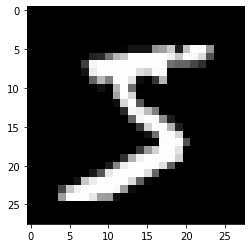

In [33]:
train, test = tf.keras.datasets.mnist.load_data()
X_train, y_train = train
X_test, y_test = test

plt.imshow(X_train[0], cmap="Greys_r")

# # Pre-process
n_train = X_train.shape[0]
n_test = X_test.shape[0]
width = X_train.shape[1]
height = X_train.shape[2]

# Normalize image to [0,1] range
X_train = (X_train.reshape([-1, width*height])/255).astype('float32')
X_test = (X_test.reshape([-1, width*height])/255).astype('float32')

# Converting labels
y_train = y_train.astype('int32')
y_test = y_test.astype('int32')

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))

In [0]:
# Hyper-parameters
n_units = 100
n_layers = 2
lr = 0.1
epochs = 50
BATCH_SIZE = 1000

# Set up a chain of hidden layers
layers = []
for layer in range(n_layers):
    layers.append(tf.keras.layers.Dense(
        n_units, activation=tf.nn.relu,
        kernel_initializer=tf.initializers.RandomUniform(minval=-0.1, 
                                                         maxval=0.1),
        bias_initializer=tf.initializers.constant(0.001)))

# finally add the softmax output layer :))
layers.append(tf.keras.layers.Dense(
    10, kernel_initializer=tf.initializers.RandomUniform(minval=-0.1,
                                                     maxval=0.1)))

In [51]:
for epoch in range(1,epochs+1):
  for X_batch, y_batch in train_ds.shuffle(n_train).batch(BATCH_SIZE):
      with tf.GradientTape() as tape:
          # here we just run all the layers in sequence via a for-loop
          out = X_batch
          for layer in layers:
              out = layer(out)
          xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
              logits=out, labels=y_batch))

      weights = [var for l in layers for var in l.trainable_variables]
      grads = tape.gradient(xent, weights)
      for grad, var in zip(grads, weights):
          var.assign_sub(lr*grad)

  if epoch % 5 == 0:
    out = X_test
    for layer in layers:
        out = layer(out)
    test_preds = tf.argmax(out, axis=1, output_type=tf.int32)
    acc = tf.reduce_mean(tf.cast(tf.equal(test_preds, y_test), tf.float32))
    print("Epoch {}, Final test accuracy: {}".format(epoch, acc))

Epoch 5, Final test accuracy: 0.9047999978065491
Epoch 10, Final test accuracy: 0.9264000058174133
Epoch 15, Final test accuracy: 0.9363999962806702
Epoch 20, Final test accuracy: 0.9430000185966492
Epoch 25, Final test accuracy: 0.9492999911308289
Epoch 30, Final test accuracy: 0.9552000164985657
Epoch 35, Final test accuracy: 0.9592000246047974
Epoch 40, Final test accuracy: 0.9628999829292297
Epoch 45, Final test accuracy: 0.9646999835968018
Epoch 50, Final test accuracy: 0.9681000113487244


In [48]:
out = X_test
for layer in layers:
    out = layer(out)
test_preds = tf.argmax(out, axis=1, output_type=tf.int32)
acc = tf.reduce_mean(tf.cast(tf.equal(test_preds, y_test), tf.float32))
print("Final test accuracy: {}".format(acc))

Final test accuracy: 0.9502000212669373


## END